In [16]:
import random
from queue import PriorityQueue
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
ARRIVAL = 1/5.0  # arrival rate λ
SERVICE = 10.0   # average service time per server (μ)
SIM_TIME = 100000
TYPE1 = 1
SEED = 42
BUFFER_SIZES = [0, 2, 5, 10, 9999]  # including "infinite" buffer (9999)

In [18]:
class Measure:
    def __init__(self):
        self.arr = 0
        self.dep = 0
        self.ut = 0
        self.oldT = 0
        self.delay = 0
        self.bs1 = 0
        self.bs2 = 0
        self.loss = 0

In [19]:
class Client:
    def __init__(self, type, arrival_time):
        self.type = type
        self.arrival_time = arrival_time

In [20]:
def run_simulation_task2b(buffer_size):
    global users, data, MM1, busy1, busy2
    users = 0
    data = Measure()
    MM1 = []
    time = 0
    FES = PriorityQueue()
    busy1 = False
    busy2 = False
    start_time_1 = None
    start_time_2 = None

    def arrival(current_time):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2
        data.arr += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        inter_arrival = random.expovariate(1.0 / ARRIVAL)
        FES.put((current_time + inter_arrival, "arrival"))

        if users < buffer_size:
            users += 1
            client = Client(TYPE1, current_time)
            MM1.append(client)

            if not busy1:
                s_time = random.expovariate(1 / SERVICE)
                start_time_1 = current_time
                FES.put((current_time + s_time, "departure1"))
                busy1 = True
            elif not busy2:
                s_time = random.expovariate(1 / SERVICE)
                start_time_2 = current_time
                FES.put((current_time + s_time, "departure2"))
                busy2 = True
        else:
            data.loss += 1

    def departure(current_time, server_id):
        nonlocal start_time_1, start_time_2
        global users, busy1, busy2
        if len(MM1) == 0:
            if server_id == 1 and busy1:
                data.bs1 += current_time - start_time_1
                busy1 = False
            elif server_id == 2 and busy2:
                data.bs2 += current_time - start_time_2
                busy2 = False
            return

        data.dep += 1
        data.ut += users * (current_time - data.oldT)
        data.oldT = current_time

        client = MM1.pop(0)
        data.delay += (current_time - client.arrival_time)
        users -= 1

        if users > 0:
            s_time = random.expovariate(1 / SERVICE)
            if server_id == 1:
                data.bs1 += current_time - start_time_1
                start_time_1 = current_time
                FES.put((current_time + s_time, "departure1"))
            else:
                data.bs2 += current_time - start_time_2
                start_time_2 = current_time
                FES.put((current_time + s_time, "departure2"))
        else:
            if server_id == 1:
                data.bs1 += current_time - start_time_1
                busy1 = False
            else:
                data.bs2 += current_time - start_time_2
                busy2 = False

    random.seed(SEED)
    FES.put((0.0, "arrival"))
    while time < SIM_TIME:
        time, event_type = FES.get()
        if event_type == "arrival":
            arrival(time)
        elif event_type == "departure1":
            departure(time, 1)
        elif event_type == "departure2":
            departure(time, 2)

    avg_delay = data.delay / data.dep if data.dep > 0 else 0
    avg_users = data.ut / time
    utilization = (data.bs1 + data.bs2) / (time * 2)
    loss_rate = data.loss / data.arr if data.arr > 0 else 0
    return avg_delay, avg_users, utilization, loss_rate


In [21]:
task2b_results = []
for b in BUFFER_SIZES:
    res = run_simulation_task2b(buffer_size=b)
    task2b_results.append({
        "Buffer Size": b,
        "Avg Delay": res[0],
        "Avg Users": res[1],
        "Utilization": res[2],
        "Loss Rate": res[3]
    })

In [22]:
# Create and print DataFrame
df_2b = pd.DataFrame(task2b_results)
print("Task 2.b - Multi-server System with Varying Buffer Sizes")
print(df_2b)

Task 2.b - Multi-server System with Varying Buffer Sizes
   Buffer Size     Avg Delay    Avg Users  Utilization  Loss Rate
0            0      0.000000     0.000000     0.000000   1.000000
1            2      9.828816     1.958368     0.999098   0.960089
2            5     24.819868     4.958284     0.999864   0.959978
3           10     49.839505     9.958226     0.999864   0.959968
4         9999  36915.023939  9893.960502     0.999864   0.939958


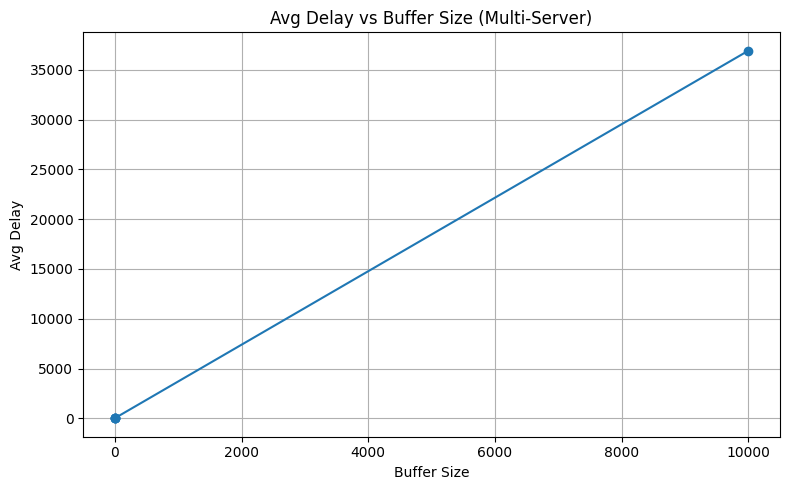

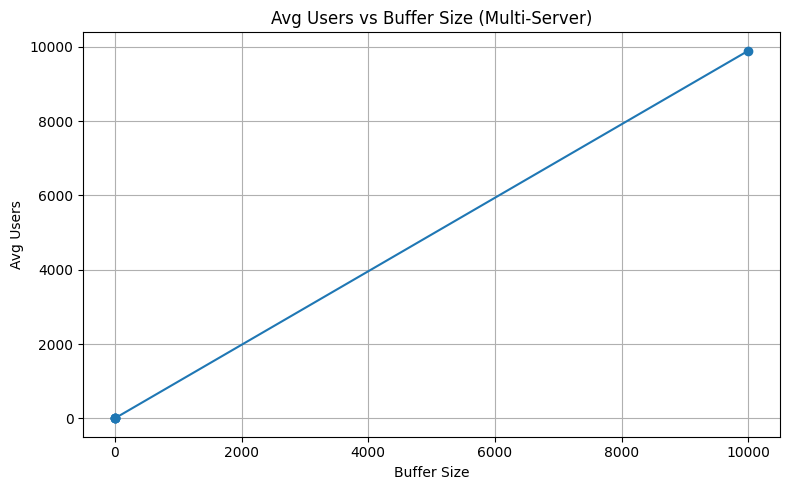

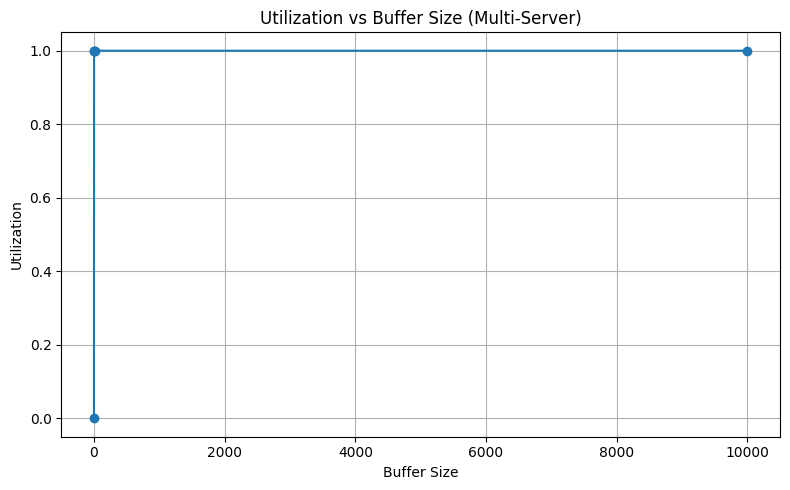

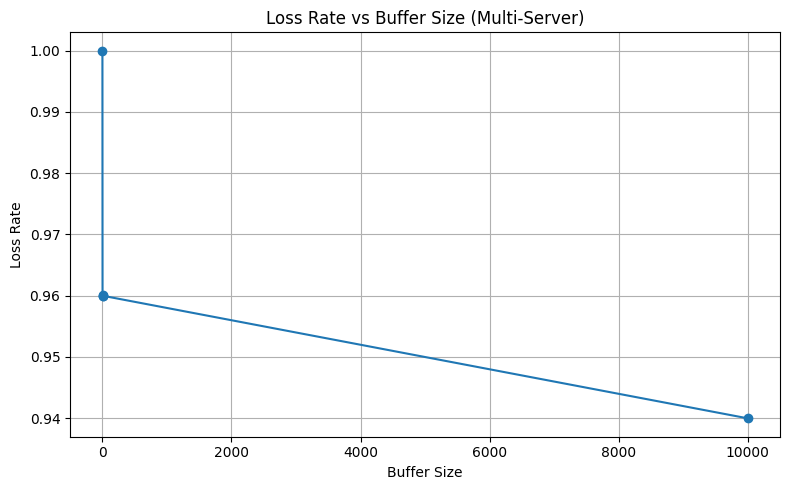

In [25]:
metrics = ["Avg Delay", "Avg Users", "Utilization", "Loss Rate"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(df_2b["Buffer Size"], df_2b[metric], marker='o')
    plt.xlabel("Buffer Size")
    plt.ylabel(metric)
    plt.title(f"{metric} vs Buffer Size (Multi-Server)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()